# Imports

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import f1_score, recall_score
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import os
import io
import sys
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from pyod.models.deep_svdd import DeepSVDD
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Scaling and Removing EventDay for one classification

In [2]:
def preprocess_for_models(df, seed=0):              
    # Get rid of asthma attack days 
    df_withoutRowEventDay = df[df['EventDay'] == 0]
    
    # Remove now usless EventDay column
    df_withoutColEventDay = df_withoutRowEventDay.drop(['EventDay'], axis = 1)

    # Initialize the StandardScaler and scale the dataframe
    scaler = StandardScaler()
    scaled_df = pd.DataFrame(scaler.fit_transform(df_withoutColEventDay), columns=df_withoutColEventDay.columns)
    
    '''
    Important note!
    Really important to use a random state here
    Since the number of exacerbations is really low we should create multiple samples of the train test split
    '''
    
    X_train, X_test = train_test_split(scaled_df, test_size=0.2, random_state=seed)

    return X_train, X_test

# Performance metrics

In [3]:
def display_confusion_matrix(cm):
    # Create a heatmap for visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

def calculate_metrics(cm):
    # Extracting values from confusion matrix
    TP = cm[0][0]
    TN = cm[1][1]
    FP = cm[0][1]
    FN = cm[1][0]

    # Performance metrics
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    specificity = TN / (TN + FP)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, specificity, f1_score

# k-Means Cluster

In [4]:
def suggested_no_of_clusters(min_clusters, max_clusters):
    # Initialize lists to store the number of clusters and corresponding WCSS values
    num_clusters = []
    wcss_values = []

    # Perform clustering for different numbers of clusters
    for k in range(min_clusters, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(df)

        # Compute the within-cluster sum of squares (WCSS)
        wcss = kmeans.inertia_

        # Append the number of clusters and WCSS values to the lists
        num_clusters.append(k)
        wcss_values.append(wcss)

    # Calculate the differences between consecutive WCSS values
    wcss_diff = [wcss_values[i] - wcss_values[i-1] for i in range(1, len(wcss_values))]

    # Find the index of the maximum difference
    max_diff_index = wcss_diff.index(max(wcss_diff))

    # Suggested number of clusters
    suggested_clusters = num_clusters[max_diff_index]

    print("Suggested number of clusters:", suggested_clusters)

    
# TODO can refine clusters for diffeent data sets
# suggested_no_of_clusters(data_train, 1, 10)

In [5]:
def k_means(df, data_train, data_pred, num_clusters=5, threshold=10):
    # Select relevant columns for clustering
    columns_to_cluster = data_train.columns

    # Extract the subset of data for clustering from training DataFrame
    data_for_clustering = data_train[columns_to_cluster]

    # Standardize the data
    scaler = StandardScaler()
    data_for_clustering_standardized = scaler.fit_transform(data_for_clustering)

    # Apply k-means clustering on training data
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data_for_clustering_standardized)

    # Get the cluster labels for training data
    training_cluster_labels = kmeans.labels_

    # Assign cluster labels to the training DataFrame
    data_train['ClusterLabel'] = training_cluster_labels

    # Check the distribution of clusters in training data
    training_cluster_counts = data_train['ClusterLabel'].value_counts()

    # Calculate cluster means on training data
    training_cluster_means = data_train.groupby('ClusterLabel').mean()

    # Extract the subset of data for anomaly prediction from predicting DataFrame
    data_for_prediction = data_pred[columns_to_cluster]

    # Standardize the data for prediction using the same scaler as training
    data_for_prediction_standardized = scaler.transform(data_for_prediction)

    # Get the cluster labels for prediction data
    prediction_cluster_labels = kmeans.predict(data_for_prediction_standardized)

    # Assign cluster labels to the predicting DataFrame
    data_pred['ClusterLabel'] = prediction_cluster_labels

    # Check the distribution of clusters in predicting data
    prediction_cluster_counts = data_pred['ClusterLabel'].value_counts()

    # Detect anomalies based on cluster means
    anomaly_rows = []
    for index, row in data_pred.iterrows():
        cluster_label = row['ClusterLabel']
        features = row[columns_to_cluster]
        cluster_mean = training_cluster_means.loc[cluster_label]
        if any(abs(features - cluster_mean) > threshold):
            anomaly_rows.append(index)

    # detected anomalies
    anomalies = data_pred.loc[anomaly_rows]
    
    df['Anomalies_KMeans'] = 0  # Initialize the column with 0 values
    df.loc[anomalies.index, 'Anomalies_KMeans'] = 1  # Set the corresponding anomalies as 1

# Isolation Forest

In [6]:
def iforest(df, data_train, data_pred, outliers_fraction=0.5):
    # Train
    ifo = IsolationForest(contamination = outliers_fraction)
    ifo.fit(data_train)

    # Predict
    df['Anomalies_IF'] = pd.Series(ifo.predict(data_pred))
    
    # Configure properly
    df['Anomalies_IF'].fillna(0, inplace=True)
    df['Anomalies_IF'] = df['Anomalies_IF'].replace(1, 0)
    df['Anomalies_IF'] = df['Anomalies_IF'].replace(-1, 1)

# OSVM

In [7]:
def ocsvm(df, data_train, data_pred, outliers_fraction=0.9):
    # Train
    osvm = OneClassSVM(nu = outliers_fraction, kernel = 'sigmoid')
    osvm.fit(data_train)

    # Predict
    df['Anomalies_OSVM'] = pd.Series(osvm.predict(data_pred))
    
    # Configure properly
    df['Anomalies_OSVM'].fillna(0, inplace=True)
    df['Anomalies_OSVM'] = df['Anomalies_OSVM'].replace(1, 0)
    df['Anomalies_OSVM'] = df['Anomalies_OSVM'].replace(-1, 1)

# Local Outlier Factor

In [8]:
def local_of(df, data_train, data_pred, outliers_fraction=0.3):
    # Train
    lof = LocalOutlierFactor(contamination=outliers_fraction)
    lof.fit(data_train)

    # Predict
    df['Anomalies_LOF'] = pd.Series(lof.fit_predict(data_pred))
    
    # Configure properly
    df['Anomalies_LOF'].fillna(0, inplace=True)
    df['Anomalies_LOF'] = df['Anomalies_LOF'].replace(1, 0)
    df['Anomalies_LOF'] = df['Anomalies_LOF'].replace(-1, 1)

# Autoencoders

In [9]:
def autoencoders(df, train, test):
    # Define the shape of the input data
    input_dim = train.shape[1]

    # Define the architecture of the autoencoder
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(32, activation='relu')(input_layer)  # Encoding layer
    decoder = Dense(input_dim, activation='linear')(encoder)  # Decoding layer

    # Create the autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=decoder)

    # Compile the model
    autoencoder.compile(optimizer='adam', loss='mse')

    # Train the autoencoder
    autoencoder.fit(train, train, epochs=50, batch_size=32, validation_data=(test, test), verbose=0)

    # Use the trained autoencoder to predict on the test dataset
    reconstructed_data = autoencoder.predict(test)

    # Calculate the mean squared error (MSE) between the original and reconstructed data
    mse = np.mean(np.power(test - reconstructed_data, 2), axis=1)

    # Define a threshold to determine outliers
    threshold = np.mean(mse) + 3 * np.std(mse)  # Adjust the multiplier (3) as per your requirements

    # Map outliers as -1 and inliers as 1
    outliers = np.where(mse > threshold, 1, 0)

    # Return anomalies
    anomalies = test.copy()
    anomalies['Anomalies_AE'] = outliers    
    
    # Add the anomaly column to the original data
    df['Anomalies_AE'] = 0  # Initialize all values as 1 (normal)
    df.iloc[test.index, -1] = anomalies['Anomalies_AE'].values  # Assign anomaly values to test data indices

# Deep Support Vector Data Description

In [10]:
def dsvdd(df, train, test):
    # Train the autoencoder
    input_dim = train.shape[1]
    input_layer = Input(shape=(input_dim,))
    
    encoder = Dense(32, activation='relu')(input_layer)  # Adjust the number of nodes in the encoder layer
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')
    autoencoder.fit(train, train, epochs=50, batch_size=32, shuffle=True, validation_data=(test, test), verbose=0)

    # Obtain the encoded representations from the trained autoencoder
    encoder_model = Model(inputs=input_layer, outputs=encoder)
    encoded_train_data = encoder_model.predict(train)
    encoded_test_data = encoder_model.predict(test)

    # Train the ODSVDDM using the encoded representations
    deep_svdd = DeepSVDD(verbose=0)
    deep_svdd.fit(encoded_train_data)

    # Predict the anomaly scores for the test data
    anomaly_scores = deep_svdd.decision_function(encoded_test_data)

    # Calculate the threshold for anomaly detection using the anomaly scores
    threshold = np.percentile(anomaly_scores, 97)  # Adjust the percentile as needed

    # Classify data points as normal (inliers) or anomalous (outliers)
    predictions = np.where(anomaly_scores > threshold, 1, 0)

    # Add the anomaly column to the original data
    df['Anomalies_DSVDD'] = 0  # Initialize all values as 1 (inliers)
    df.iloc[test.index, -1] = predictions  # Assign anomaly values to test data indices

# Load any preprocessed File

In [11]:
# Move up 2 directories
data_directory = '../..' 

# Load the CSV files
asthma_df = pd.read_csv(os.path.join(data_directory, 'Data\Preprocessed', 'preprocessed_MICE_asthma.csv'))
healthy_df = pd.read_csv(os.path.join(data_directory, 'Data\Preprocessed', 'preprocessed_MICE_healthy.csv'))

# Merged df
merged_df = pd.concat([asthma_df, healthy_df], ignore_index=True)

In [12]:
merged_df.head(5)

,DayNo,Age,weight,height,BMI_SDS,PedsQL_score_baseline,stepsTotalDaily,steps_hour_max,steps07,steps08,steps09,steps10,steps11,steps12,steps13,steps14,steps15,steps16,steps17,steps18,steps19,steps20,HR05Perc,HR95Perc,HRMinSleep,HRMaxSleep,AVGHR_daily,AVGHR_sleep,AVGHR_wake,HR00,HR01,HR02,HR03,HR04,HR05,HR06,HR07,HR08,HR09,HR10,HR11,HR12,HR13,HR14,HR15,HR16,HR17,HR18,HR19,HR20,HR21,HR22,HR23,wear05H,wear16H,wear24H,awakeDuration,lightSleepDuration,deepSleepDuration,wakeUpCount,FG,FHX,FHN,TG,TN,TX,SQ,SP,DR,RH,RHX,EventDay,weekday_Fri,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed,dayType_holiday,dayType_school,dayType_weekend,school_yes_no_no,school_yes_no_yes,sex_Female,sex_Male,sportsyesno_No,sportsyesno_Yes,urbanisation_Extremely urbanised,urbanisation_Not extremely urbanised,grade_fev1_A,grade_fev1_B,grade_fev1_C,grade_fev1_D,grade_fev1_E,grade_fev1_F,grade_fev1_U,grade_fvc_A,grade_fvc_B,grade_fvc_C,grade_fvc_D,grade_fvc_E,grade_fvc_F,grade_fvc_U,screentime_0-30 min,screentime_0.5-1 hours,screentime_1-2 hours,screentime_2-4 hours,screentime_> 4 hours
0,0.0,15.0,51.9,163.2,-0.1,847826087.0,3723.0,1640.0,147.660462,198.589585,63.0,137.0,449.061499,205.326828,605.0,1640.0,514.09455,82.0,451.0,245.0,135.0,160.0,68.0,120.0,61.0,93.0,90.0,75.312548,94.0,72.354658,70.32749,72.162935,72.645209,70.346684,70.987121,73.239849,85.81755,94.229593,91.550898,93.735671,120.0,96.217727,93.848718,102.29268,95.356064,94.624175,89.8,83.4,87.8,91.5,93.30,77.1,78.6,0.0,69.0,54.0,660.0,16800.0,16440.0,1.0,6.3,8.0,4.0,14.0,85.0,19.7,5.4,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,15.0,51.9,163.2,-0.1,847826087.0,10015.0,4355.0,41.399402,607.000000,580.0,325.0,180.000000,322.000000,181.0,491.0,161.00000,10.0,744.0,1146.0,4355.0,722.0,82.0,168.0,67.0,121.0,94.0,76.000000,102.0,73.600000,75.20000,70.750000,92.000000,76.000000,70.300000,82.300000,78.00000,99.000000,113.000000,129.800000,95.1,91.600000,105.358749,108.50000,85.250000,93.400000,95.8,101.8,142.3,107.8,104.20,91.8,93.0,100.0,100.0,100.0,180.0,22200.0,11760.0,0.0,10.0,12.0,8.0,11.3,100.0,13.1,0.2,2.0,0.9,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,2.0,15.0,51.9,163.2,-0.1,847826087.0,3811.0,727.0,63.000000,561.000000,159.0,356.0,26.000000,591.000000,109.0,114.0,456.00000,155.0,727.0,46.0,139.0,210.0,71.0,122.0,64.0,129.0,90.0,77.000000,96.0,79.100000,73.10000,80.300000,78.000000,76.100000,74.600000,78.100000,98.50000,103.400000,100.500000,109.600000,100.6,105.000000,109.000000,86.50000,88.600000,102.800000,78.2,85.2,94.0,100.0,89.25,96.5,82.0,100.0,100.0,100.0,300.0,19260.0,12360.0,1.0,6.0,9.0,4.0,9.9,62.0,13.3,8.2,89.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,15.0,51.9,163.2,-0.1,847826087.0,4346.0,673.0,119.919027,515.000000,673.0,377.0,490.000000,192.000000,322.0,180.0,523.00000,61.0,359.0,174.0,95.0,148.0,66.0,128.0,59.0,107.0,88.0,75.000000,93.0,77.100000,79.80000,72.600000,67.000000,80.200000,76.000000,73.600000,79.00000,98.500000,103.500000,106.400000,95.5,106.200000,98.200000,100.00000,84.300000,86.800000,97.2,74.0,107.0,82.4,96.10,90.8,78.2,100.0,100.0,100.0,1140.0,17041.0,19619.0,1.0,6.9,10.0,4.0,9.5,63.0,11.7,3.2,35.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,4.0,15.0,51.9,163.2,-0.1,847826087.0,3270.0,1324.0,27.834972,223.003456,50.0,92.0,167.000000,1324.000000,388.0,166.0,101.00000,91.0,6.0,224.0,405.0,56.0,64.0,111.0,57.0,88.0,81.0,77.000000,83.0,83.300000,77.60000,75.100000,76.200000,72.600000,75.800000,73.800000,68.00000,74.800000,65.400000,94.400000,85.7,77.2

# Preprocess data for models (Removing eventdate and scaling the data)

In [13]:
# Preprocess for models
train, pred = preprocess_for_models(merged_df)

# Run all models and store anomaly results in merged_df
k_means(merged_df, train, pred)
iforest(merged_df, train, pred)
local_of(merged_df, train, pred)
ocsvm(merged_df, train, pred)
autoencoders(merged_df, train, pred) 
dsvdd(merged_df, train, pred)

40/40 [==============================] - 0s 1ms/step


# Obtain performance metrics

Anomalies_KMeans


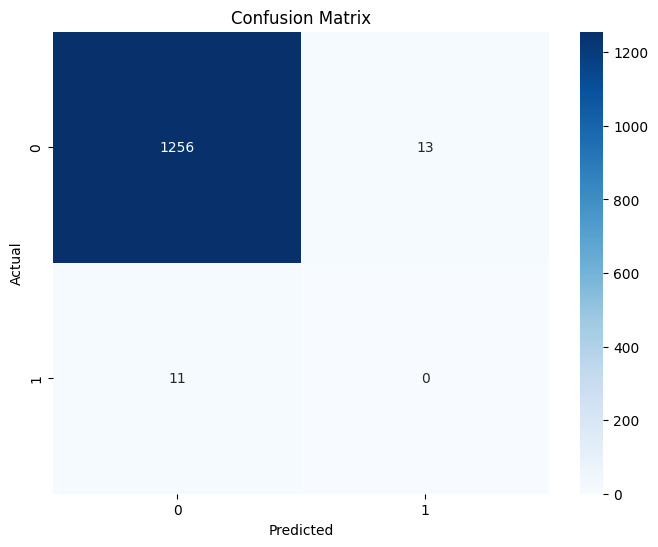

Accuracy: 0.98125 
Precision: 0.9897557131599685 
Recall: 0.9913180741910024 
Specificity: 0.0 
F1 Score: 0.9905362776025236


In [14]:
# Only use the test dataset to calculate performance metrics
subset_df = merged_df.loc[pred.index]

print("Anomalies_KMeans")
cm = confusion_matrix(subset_df['Anomalies_KMeans'].values, subset_df['EventDay'].values)
display_confusion_matrix(cm)
accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)
print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, 
      "\nSpecificity:", specificity, "\nF1 Score:", f1_score)

Anomalies_IF


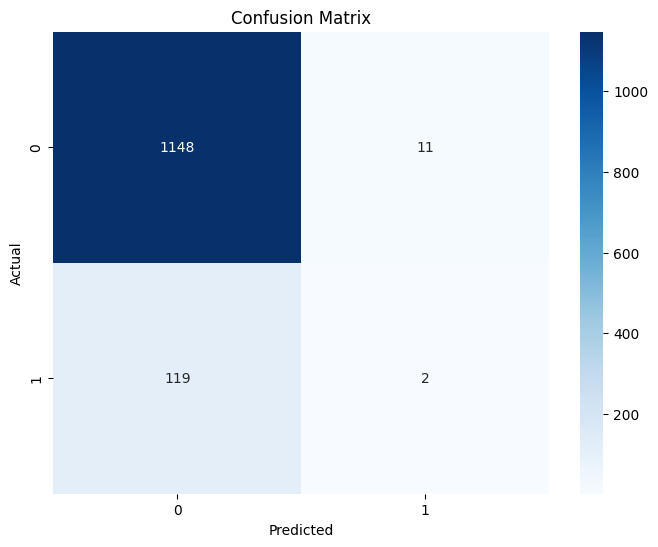

Accuracy: 0.8984375 
Precision: 0.9905090595340811 
Recall: 0.9060773480662984 
Specificity: 0.15384615384615385 
F1 Score: 0.9464138499587799


In [15]:
print("Anomalies_IF")
cm = confusion_matrix(subset_df['Anomalies_IF'].values, subset_df['EventDay'].values)
display_confusion_matrix(cm)
accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)
print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, 
      "\nSpecificity:", specificity, "\nF1 Score:", f1_score)

Anomalies_OSVM


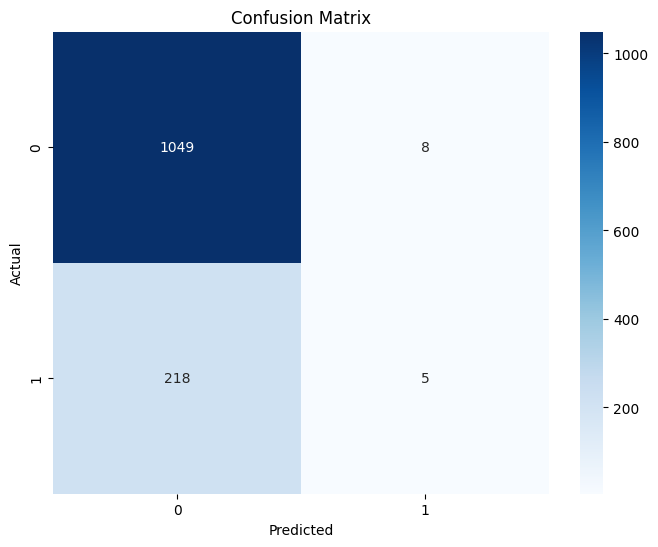

Accuracy: 0.8234375 
Precision: 0.9924314096499527 
Recall: 0.8279400157853196 
Specificity: 0.38461538461538464 
F1 Score: 0.9027538726333907


In [16]:
print("Anomalies_OSVM")
cm = confusion_matrix(subset_df['Anomalies_OSVM'].values, subset_df['EventDay'].values)
display_confusion_matrix(cm)
accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)
print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, 
      "\nSpecificity:", specificity, "\nF1 Score:", f1_score)

Anomalies_LOF


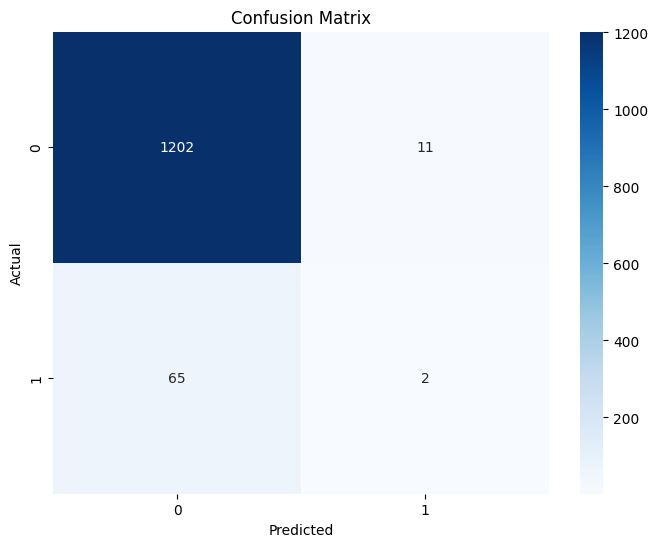

Accuracy: 0.940625 
Precision: 0.9909315746084089 
Recall: 0.9486977111286503 
Specificity: 0.15384615384615385 
F1 Score: 0.9693548387096774


In [17]:
print("Anomalies_LOF")
cm = confusion_matrix(subset_df['Anomalies_LOF'].values, subset_df['EventDay'].values)
display_confusion_matrix(cm)
accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)
print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, 
      "\nSpecificity:", specificity, "\nF1 Score:", f1_score)

Anomalies_AE


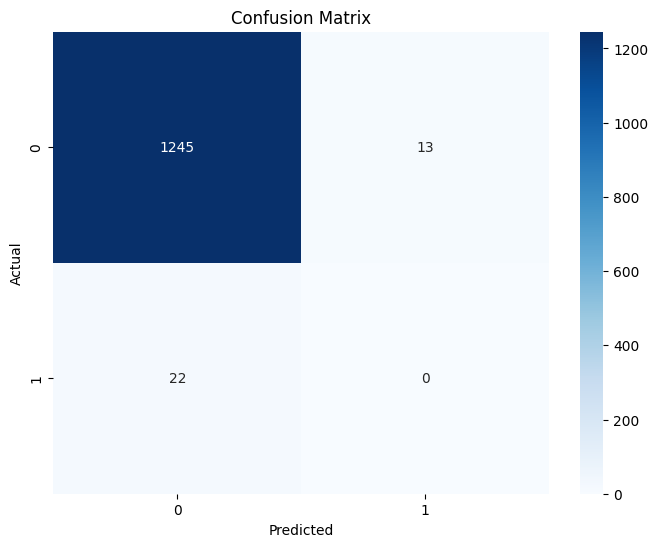

Accuracy: 0.97265625 
Precision: 0.9896661367249603 
Recall: 0.9826361483820047 
Specificity: 0.0 
F1 Score: 0.986138613861386


In [18]:
print("Anomalies_AE")
cm = confusion_matrix(subset_df['Anomalies_AE'].values, subset_df['EventDay'].values)
display_confusion_matrix(cm)
accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)
print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, 
      "\nSpecificity:", specificity, "\nF1 Score:", f1_score)

Anomalies_DSVDD


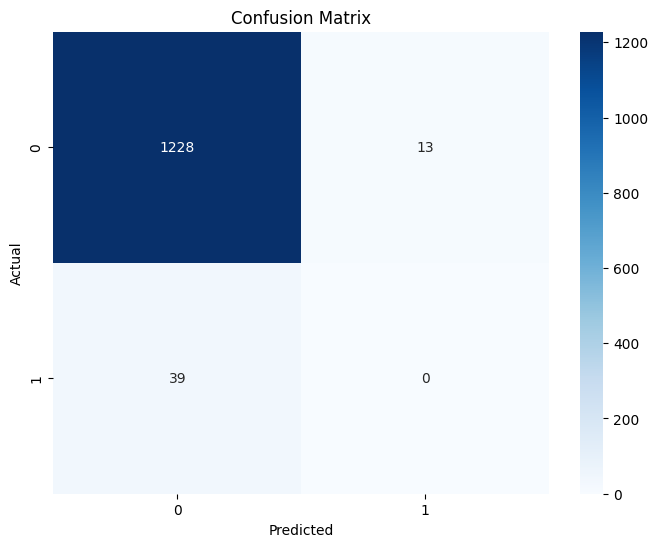

Accuracy: 0.959375 
Precision: 0.9895245769540693 
Recall: 0.9692186266771902 
Specificity: 0.0 
F1 Score: 0.9792663476874002


In [19]:
print("Anomalies_DSVDD")
cm = confusion_matrix(subset_df['Anomalies_DSVDD'].values, subset_df['EventDay'].values)
display_confusion_matrix(cm)
accuracy, precision, recall, specificity, f1_score = calculate_metrics(cm)
print("Accuracy:", accuracy, "\nPrecision:", precision, "\nRecall:", recall, 
      "\nSpecificity:", specificity, "\nF1 Score:", f1_score)

# Best configuration of train/test split

In [ ]:
num_iterations = 100
best_seed = None
best_f1_score = 0.0

# Perform train-test split for different random seeds
# Use the best seed as default train test split
for i in tqdm(range(num_iterations)):
    seed = i  # Set the seed for each iteration

    # Preprocess for models
    merged_df = pd.concat([asthma_df, healthy_df], ignore_index=True)
    
    # Create train test split
    train, test = preprocess_for_models(merged_df, seed)
    
    # Run all models and store anomaly results in merged_df
    k_means(merged_df, train, test)
    iforest(merged_df, train, test)
    local_of(merged_df, train, test)
    ocsvm(merged_df, train, test)
    autoencoders(merged_df, train, test) 
    dsvdd(merged_df, train, test)
    
    # Get all f1 scores and average the number
    subset_df = merged_df.loc[test.index]
    cm = confusion_matrix(subset_df['Anomalies_KMeans'].values, subset_df['EventDay'].values)
    _, _, _, _, f1 = calculate_metrics(cm)
    
    cm = confusion_matrix(subset_df['Anomalies_IF'].values, subset_df['EventDay'].values)
    _, _, _, _, f2 = calculate_metrics(cm)
    
    cm = confusion_matrix(subset_df['Anomalies_OSVM'].values, subset_df['EventDay'].values)
    _, _, _, _, f3 = calculate_metrics(cm)
    
    cm = confusion_matrix(subset_df['Anomalies_LOF'].values, subset_df['EventDay'].values)
    _, _, _, _, f4 = calculate_metrics(cm)
    
    cm = confusion_matrix(subset_df['Anomalies_AE'].values, subset_df['EventDay'].values)
    _, _, _, _, f5 = calculate_metrics(cm)
    
    cm = confusion_matrix(subset_df['Anomalies_DSVDD'].values, subset_df['EventDay'].values)
    _, _, _, _, f6 = calculate_metrics(cm)
    
    f_score = (f1 + f2 + f3 + f4 + f5 + f6) / 6 
    
    # Update the best F1 score and seed if necessary
    if f_score > best_f1_score:
        best_f1_score = f_score
        best_seed = seed

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

In [ ]:
print("Best Seed:", best_seed)
print("Best F1 Score:", best_f1_score)

train.to_csv('optimal_train.csv', index=False)
test.to_csv('optimal_test.csv', index=False)

# TODO FEATURE SELECTION
# TODO TWEAK PARAMETERS